In [3]:
import pandas as pd
import numpy as np
import os
import sys
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-song-audio")

print("Path to dataset files:", path)

100%|██████████| 456M/456M [00:07<00:00, 67.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-song-audio/versions/1


In [5]:
actors_folders = [os.path.join(path, folder) for folder in os.listdir(path) if os.path.isdir(os.path.join(path, folder))]
# Debugging: List all actor folders
print("Actor folders found:", actors_folders)

# Collect all audio file paths
audio_files = []
for actor_folder in actors_folders:
    for f in os.listdir(actor_folder):
        if f.endswith('.wav'):  # Ensure it's an audio file
            audio_files.append(os.path.join(actor_folder, f))

print("Found audio files:", len(audio_files))

Actor folders found: ['/root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-song-audio/versions/1/Actor_21', '/root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-song-audio/versions/1/Actor_07', '/root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-song-audio/versions/1/Actor_19', '/root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-song-audio/versions/1/Actor_08', '/root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-song-audio/versions/1/Actor_05', '/root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-song-audio/versions/1/Actor_24', '/root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-song-audio/versions/1/Actor_13', '/root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-song-audio/versions/1/Actor_20', '/root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-song-audio/versions/1/Actor_03', '/root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-song-audio/versions/1/Actor_04', '/root/.cache/kagg

In [6]:
for audio_file in audio_files:
    # Load the specific audio file
    #y will contain the amplitude values of the audio signal, and sr will contain the sampling rate of the audio ex4000hz
    y, sr = librosa.load(audio_file, sr=None)

    # Apply noise reduction
    y_without_noise = librosa.effects.preemphasis(y)

    # Apply normalization
    y_normalized = librosa.util.normalize(y)

    # For debugging, you can print the file being processed
    # print(f"Processed {audio_file} with sampling rate {sr}")

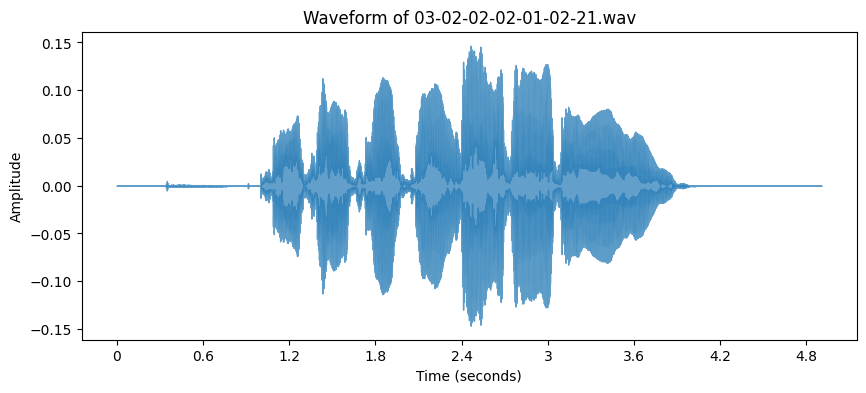

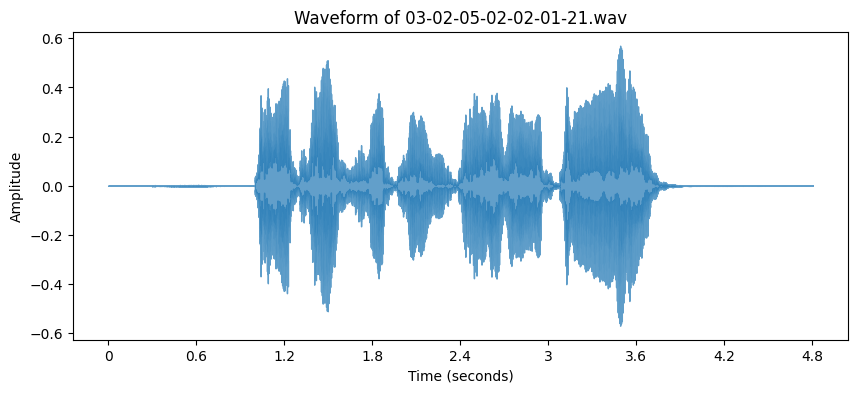

In [7]:
def plot_waveform(file_path):
    y, sr = librosa.load(file_path, sr=None)

    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(y, sr=sr, alpha=0.7)
    plt.title(f"Waveform of {os.path.basename(file_path)}")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.show()

# Example: Plot a calm and angry audio sample
calm_audio = [f for f in audio_files if "-02-" in f][0] #calm sample
angry_audio = [f for f in audio_files if "-05-" in f][0]  #angry sample

plot_waveform(calm_audio)
plot_waveform(angry_audio)

In [8]:
def get_label(file_path):
    """Extract emotion label from filename"""
    file_name = os.path.basename(file_path)
    emotion_id = int(file_name.split("-")[2])  # Extracting the XX part (emotion)

    if emotion_id == 2:
        return 0  # Calm
    elif emotion_id == 5:
        return 1  # Angry
    else:
        return None  # Ignore other emotions

In [9]:
def extract_features(y, sr):
    # Extract features: MFCC, spectral centroid, spectral rolloff, and zero-crossing rate
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).mean(axis=1) #They are derived by applying a Fourier transform on the audio signal and capture quality of sound
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr).mean() #brightness of a sound. A higher spectral centroid means the sound has more high-frequency components
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr).mean() #It can help distinguish between harmonic and non-harmonic (noisy) content.
    zcr = librosa.feature.zero_crossing_rate(y).mean() #it distinguishes between voiced sounds (like vowels) have low zero-crossing rates and unvoiced sounds tend to have higher zero-crossing rates.

    return np.hstack([mfccs, spectral_centroid, spectral_rolloff, zcr])

In [10]:
def prepare_dataset(file_paths):
    X = []
    y = []

    for file_path in file_paths:
        label = get_label(file_path)

        if label is None:  # Skip files that are not Angry or Calm
            continue

        y_signal, sr = librosa.load(file_path, sr=None)
        features = extract_features(y_signal, sr)

        X.append(features)
        y.append(label)

    return np.array(X), np.array(y)

In [11]:
X, y = prepare_dataset(audio_files)
print(f"Total samples: {len(X)}")
print(f"Feature shape: {X.shape}")
print(f"Class distribution: {np.bincount(y)}")  # Count occurrences of each class

Total samples: 368
Feature shape: (368, 16)
Class distribution: [184 184]


In [15]:
class gnb:
    def __init__(self):
        self.prior = None
        self.n_class = None
        self.mean = None
        self.variance = None
        self.classes = None

    def fit(self, X, y):
        X_df = pd.DataFrame(X)  # Convert NumPy array to DataFrame
        self.mean = X_df.groupby(by=y).mean().values
        self.variance = X_df.groupby(by=y).var().values
        self.n_class = len(np.unique(y))
        self.classes = np.unique(y)
        self.prior = 1 / self.n_class  # Equal priors assumed
        return self

    def gnb_base(self, x_val, x_mean, x_var):
        pi = np.pi
        e = np.e
        eq_1 = 1 / (np.sqrt(2 * pi * x_var))
        exp_term = np.exp(-((x_val - x_mean) ** 2) / (2 * x_var))
        return eq_1 * exp_term

    def predict(self, X):
        X = np.array(X)  # Ensure input is a NumPy array
        split_class = np.array(self.mean), np.array(self.variance)

        predictions = []
        for sample in X:  # Iterate over test samples
            prob_classes = []
            for i in range(self.n_class):
                mean_class, var_class = split_class[0][i], split_class[1][i]
                likelihood = np.prod([self.gnb_base(sample[j], mean_class[j], var_class[j]) for j in range(len(sample))])
                prob_classes.append(likelihood * self.prior)
            predictions.append(self.classes[np.argmax(prob_classes)])  # Select class with max probability
        return np.array(predictions)

In [16]:
X, y = prepare_dataset(audio_files)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Naive Bayes model
model = gnb()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Accuracy & Metrics
accuracy = np.mean(y_pred == y_test)
print(f"Model Accuracy: {accuracy:.2f}")

# Precision, Recall, F1-Score
print("Classification Report:\n", classification_report(y_test, y_pred))


Model Accuracy: 0.88
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.86      0.89        44
           1       0.82      0.90      0.86        30

    accuracy                           0.88        74
   macro avg       0.87      0.88      0.88        74
weighted avg       0.88      0.88      0.88        74



# Logistic Regression without Bagging



In [21]:
import numpy as np

class LogisticRegression:
    def __init__(self, learning_rate=0.01, num_iterations=700):
        # Hyperparameters
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.weights = None
        self.bias = None

    def sigmoid(self, z):

        return 1 / (1 + np.exp(-z))

    def find_z(self, X):

        return np.dot(X, self.weights) + self.bias

    def loss(self, y, y_hat):

        N = len(y)
        small_value = 1e-15  # to avoid log(0)
        y_hat = np.clip(y_hat, small_value, 1 - small_value)  # Clip values for stability
        return -(1 / N) * np.sum(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))

    def fit(self, X, y):

        self.weights = np.zeros((X.shape[1], 1))  # 2-> two features , 1 -> one column
        self.bias = 0
        N = len(y)

        for epoch in range(self.num_iterations):

          i = np.random.randint(N)

          for i in range(N) :

            sample = X[i].reshape(1, X.shape[1])
            label = y[i]

            z = self.find_z(sample)
            y_hat = self.sigmoid(z)

            # backword
            delta_w = (y_hat - label) * sample.T
            delta_b =  (y_hat - label).item()

            # update
            self.weights = self.weights - self.learning_rate * delta_w
            self.bias =self.bias - self.learning_rate * delta_b




    def predict(self, X):

        z = self.find_z(X)
        y_hat = self.sigmoid(z)
        return (y_hat >= 0.5).astype(int)  # Classify as 1 if >= 0.5, else 0

    def predict_proba(self, X):
        """
        Predict probabilities for each class (for logistic regression, this is the probability of class 1).
        """
        z = self._find_z(X)
        return self._sigmoid(z)  # Output probabilities between 0 and 1


In [22]:
# Initialize and train the model
model = LogisticRegression(learning_rate=0.01, num_iterations=200)
model.fit(X_train, y_train)  # This should store weights and bias in the model

# Make predictions (no need to pass weights and bias - they're stored in the model)
y_pred = model.predict(X_test )

# Calculate accuracy
correct = 0
for i in range(len(y_test)):
    if y_pred[i] == y_test[i]:  # You forgot the 'if' statement
        correct += 1

accuracy = (correct / len(y_test)) * 100
print(f"Accuracy: {accuracy:.2f}%")

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

<ipython-input-21-c072e13518d3>:13: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Accuracy: 74.32%
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.70      0.77        44
           1       0.65      0.80      0.72        30

    accuracy                           0.74        74
   macro avg       0.74      0.75      0.74        74
weighted avg       0.76      0.74      0.75        74



# Apply Bagging with Naïve Bayes and Logistic Regression

In [52]:
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.utils import shuffle

def bagging_naive_bayes(X_train, y_train, X_test, number_of_bags):

  n_samples = len(X_train)

  X_train , y_train = shuffle(X_train , y_train , random_state=42)

  predictions = []

  for bag in range(number_of_bags):
    indices = np.random.choice(n_samples, size=n_samples, replace=True)
    X_bag = X_train[indices]
    y_bag = y_train[indices]

    model = gnb()
    model.fit(X_bag, y_bag)
    predictions.append(model.predict(X_test))


  predictions = np.array(predictions)



  # print(predictions)  # 10 lists each has 74 value predicted
  final_predictions = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions)

  return final_predictions



In [13]:
naive_bayes_bagging_predicted =  bagging_naive_bayes(X_train, y_train, X_test, number_of_bags=10)

# print(naive_bayes_bagging_predicted)

correct = 0
for i in range(len(y_test)):
  if naive_bayes_bagging_predicted[i] == y_test[i]:
    correct += 1

correct = (correct / len(y_test)) * 100
print("aacuracy of bagging in naive bayes : " , correct)

print("Classification Report:\n", classification_report(y_test, naive_bayes_bagging_predicted))


aacuracy of bagging in naive bayes :  87.83783783783784
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.84      0.88        38
           1       0.85      0.92      0.88        36

    accuracy                           0.88        74
   macro avg       0.88      0.88      0.88        74
weighted avg       0.88      0.88      0.88        74



# Logistic Regression with Bagging

In [23]:
def bagging_logistic_regression(X_train, y_train, X_test, number_of_bags):
    n_samples = len(X_train)
    predictions = []

    for bag in range(number_of_bags):
        # Shuffle and sample with replacement
        indices = np.random.choice(n_samples, size=n_samples, replace=True)
        X_bag = X_train[indices]
        y_bag = y_train[indices]

        model = LogisticRegression(learning_rate=0.01, num_iterations=1000)
        model.fit(X_bag, y_bag)
        y_pred = model.predict(X_test)
        predictions.append(y_pred)

    predictions = np.array(predictions)
    final_predictions = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions)

    return final_predictions


In [24]:
logistic_regression_bagging_predicted = bagging_logistic_regression(X_train, y_train, X_test, number_of_bags=10)

correct = 0
for i in range(len(y_test)):
    if logistic_regression_bagging_predicted[i] == y_test[i]:
        correct += 1

accuracy = (correct / len(y_test)) * 100
print("Accuracy of bagging in logistic regression:", accuracy)
print("Classification Report:\n", classification_report(y_test, logistic_regression_bagging_predicted))


<ipython-input-21-c072e13518d3>:13: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Accuracy of bagging in logistic regression: 70.27027027027027
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.59      0.70        44
           1       0.59      0.87      0.70        30

    accuracy                           0.70        74
   macro avg       0.73      0.73      0.70        74
weighted avg       0.75      0.70      0.70        74



In [25]:
!pip install playsound

  Preparing metadata (setup.py) ... done
  Created wheel for playsound: filename=playsound-1.3.0-py3-none-any.whl size=7020 sha256=a4db06798056b125841b758cab333af2433654c1af050d5db98f75ded3426772
  Stored in directory: /root/.cache/pip/wheels/50/98/42/62753a9e1fb97579a0ce2f84f7db4c21c09d03bb2091e6cef4
Successfully built playsound


In [26]:
!pip install SpeechRecognition

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.9/32.9 MB 30.0 MB/s eta 0:00:00


In [27]:
!pip install pipwin
!pip win install pyaudio

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.3 MB/s eta 0:00:00
  Created wheel for pipwin: filename=pipwin-0.5.2-py2.py3-none-any.whl size=8770 sha256=2a149c9e453025f11542c3edde8021d1e7d59307d919bf638ceb653321cc3709
  Stored in directory: /root/.cache/pip/wheels/07/45/2e/51ee464b7c3407327439df34c2fc62f978a1e5084aaf23d201
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=7abdaa10f045de2f1addbe48343f692a653d88c7afb362ebbf345ee55a2ed07d
  Stored in directory: /root/.cache/pip/wheels/1a/b0/8c/4b75c4116c31f83c8f9f047231251e13cc74481cca4a78a9ce
  Created wheel for pyjsparser: filename=pyjsparser-2.7.1-py3-none-any.whl size=25982 sha256=7d5408b3f9604448f8b40f350691999a4ab7e49d3cd07ce21dd8eda654a29ba7
  Stored in directory: /root/.cache/pip/wheels/a5/9a/30/1003e89ab4555b81840ca46d361bf184f1e6ad880cae3b62a9
Successfully b

In [29]:
import speech_recognition as sr
import soundfile as sf
import numpy as np
import librosa

def get_audio_and_predict(model):
    r = sr.Recognizer()

    with sr.Microphone() as source:
        print("Say something (5 seconds max)...")
        r.adjust_for_ambient_noise(source, duration=1)
        audio = r.listen(source, phrase_time_limit=5)

    # Save the audio to a file
    wav_path = "user_input.wav"
    with open(wav_path, "wb") as f:
        f.write(audio.get_wav_data())

    # Process the saved audio file with librosa
    y, sr_rate = librosa.load(wav_path, sr=None)
    y = librosa.effects.preemphasis(y)
    y = librosa.util.normalize(y)

    # Extract features
    features = extract_features(y, sr_rate).reshape(1, -1)

    # Predict emotion
    prediction = model.predict(features)[0]
    emotion = "Calm" if prediction == 0 else "Angry"
    print(f"Predicted Emotion: {emotion}")

In [ ]:
get_audio_and_predict(model = LogisticRegression(learning_rate=0.01, num_iterations=200))

In [ ]:
from gtts import gTTS
import playsound

def speak(text):
    tts = gTTS(text=text, lang='en')
    filename = "temp.mp3"
    tts.save(filename)
    playsound.playsound(filename)
    os.remove(filename)

In [ ]:
speak(f"I think you sound {emotion}")

In [34]:
!apt-get install -y portaudio19-dev

!pip install PyAudio


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libportaudio2 libportaudiocpp0
Suggested packages:
  portaudio19-doc
The following NEW packages will be installed:
  libportaudio2 libportaudiocpp0 portaudio19-dev
0 upgraded, 3 newly installed, 0 to remove and 30 not upgraded.
Need to get 188 kB of archives.
After this operation, 927 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libportaudio2 amd64 19.6.0-1.1 [65.3 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libportaudiocpp0 amd64 19.6.0-1.1 [16.1 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 portaudio19-dev amd64 19.6.0-1.1 [106 kB]
Fetched 188 kB in 1s (191 kB/s)
Selecting previously unselected package libportaudio2:amd64.
(Reading database ... 126315 files and directories currently installed.)
Preparing to unpack .../libportaudio2_19.6.0-1.